In [1]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import cv2
import shutil
from glob import glob
# Helper libraries
import matplotlib.pyplot as plt
import math
%matplotlib inline
print(tf.__version__)

In [2]:
data_root='/kaggle/input/covidct/'
path_positive_cases = os.path.join('/kaggle/input/covidct/CT_COVID/')
path_negative_cases = os.path.join('/kaggle/input/covidct/CT_NonCOVID/')

### Datasets Overview 

In [3]:
# jpg and png files
positive_images_ls = glob(os.path.join(path_positive_cases,"*.png"))

negative_images_ls = glob(os.path.join(path_negative_cases,"*.png"))
negative_images_ls.extend(glob(os.path.join(path_negative_cases,"*.jpg")))

In [4]:
covid = {'class': 'CT_COVID',
         'path': path_positive_cases,
         'images': positive_images_ls}

non_covid = {'class': 'CT_NonCOVID',
             'path': path_negative_cases,
             'images': negative_images_ls}

In [5]:
df = pd.DataFrame(columns=['height', 'width'])
liste = []

for img_name in os.listdir(path_positive_cases):
    img = cv2.imread(os.path.join(path_positive_cases, img_name))
    liste.append(img.shape[:-1])

for img_name in os.listdir(path_negative_cases):
    img = cv2.imread(os.path.join(path_negative_cases, img_name))
    liste.append(img.shape[:-1])

df['height'] = list(zip(*liste))[0]
df['width'] = list(zip(*liste))[1]

In [6]:
df.describe()

In [7]:
fig = plt.figure(1, figsize=(20, 3))
plt.subplot(121)
# plot the image height
plt.hist(df['height'])
plt.title('Distribution of Image Height')
plt.xlabel('Image Height')
plt.ylabel('Count')
plt.subplot(122)
plt.hist(df['width'])
plt.title('Distribution of Image Width')
plt.xlabel('Image Width')
plt.ylabel('Count')

plt.show()

In [8]:
total_positive_covid = len(positive_images_ls)
total_negative_covid = len(negative_images_ls)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

In [9]:
image_positive = cv2.imread(os.path.join(positive_images_ls[1]))
image_negative = cv2.imread(os.path.join(negative_images_ls[5]))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_negative)
f.add_subplot(1,2, 2)
plt.imshow(image_positive)

In [10]:
print("Image COVID Shape {}".format(image_positive.shape))
print("Image Non COVID Shape {}".format(image_negative.shape))

### Create Train-Test Directory 

In [11]:
# Create Train-Test Directory
subdirs  = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['CT_COVID', 'CT_NonCOVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [12]:
# Copy Images to test set

# seed random number generator
random.seed(123)
# define ratio of pictures used for testing 
test_ratio = 0.15


for cases in [covid, non_covid]:
    total_cases = len(cases['images']) #number of total images
    num_to_select = int(test_ratio * total_cases) #number of images to copy to test set
    
    print(cases['class'], num_to_select)
    
    list_of_random_files = random.sample(cases['images'], num_to_select) #random files selected

    for files in list_of_random_files:
        shutil.copy2(files, 'test/' + cases['class'])

In [13]:
# Copy Images to train set
for cases in [covid, non_covid]:
    image_test_files = os.listdir('test/' + cases['class']) # list test files 
    for images in cases['images']:
        if images.split('/')[-1] not in (image_test_files): #exclude test files from shutil.copy
            shutil.copy2(images, 'train/' + cases['class'])

In [14]:
total_train_covid = len(os.listdir('/kaggle/working/train/CT_COVID'))
total_train_noncovid = len(os.listdir('/kaggle/working/train/CT_NonCOVID'))
total_test_covid = len(os.listdir('/kaggle/working/test/CT_COVID'))
total_test_noncovid = len(os.listdir('/kaggle/working/test/CT_NonCOVID'))

print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))

### Simple CNN Model
[Tensorflow Tutorial](https://www.tensorflow.org/tutorials/images/classification)

In [15]:
batch_size = 256
epochs = 250
IMG_HEIGHT = 300
IMG_WIDTH = 300

In [16]:
"""train_image_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest') """

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [17]:
train_dir = os.path.join('/kaggle/working/train')
test_dir = os.path.join('/kaggle/working/test')


total_train = total_train_covid + total_train_noncovid
total_test = total_test_covid + total_test_noncovid

In [18]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

In [19]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

### Building powerful image classification models using very little data

In this tutorial, we will present a few simple yet effective methods that you can use to build a powerful image classifier, using only very few training examples --just a few hundred or thousand pictures from each class you want to be able to recognize.

We will go over the following options:

* training a small network from scratch (as a baseline)
* using the bottleneck features of a pre-trained network
* fine-tuning the top layers of a pre-trained network

This will lead us to cover the following Keras features:

fit_generator for training Keras a model using Python data generators
ImageDataGenerator for real-time data augmentation
layer freezing and model fine-tuning
...and more.

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

#### Note: You will need Keras version 2.0.0 or higher to run them.

That is very few examples to learn from, for a classification problem that is far from simple. So this is a challenging machine learning problem, but it is also a realistic one: in a lot of real-world use cases, even small-scale data collection can be extremely expensive or sometimes near-impossible (e.g. in medical imaging). Being able to make the most out of very little data is a key skill of a competent data scientist.

## Training a small network from scratch (as a baseline)

In [20]:
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(1)
])

In [21]:
model.compile(optimizer='RMSprop',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

In [23]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=10)
check_point = ModelCheckpoint("./my_model.h5", monitor="val_loss", save_best_only=True)
reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=6)

callbacks_list = [early, check_point, reduce]

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=total_test // batch_size,
    callbacks=callbacks_list
)

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

### Load Best Model

In [26]:
with open("model.json", "r") as json_file:
    json = json_file.read()

# load the json file
# here i use json as loaded content of json file
model = keras.models.model_from_json(json)
model.load_weights("my_model.h5")

### Attention Map

In [27]:
layer_outputs = [layer.output for layer in model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

In [28]:
from keras.preprocessing import image


img = image.load_img(negative_images_ls[6], target_size=(IMG_HEIGHT, IMG_WIDTH))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

In [29]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

In [30]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 31], cmap='viridis')
plt.show()

In [31]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

### Class Map

In [32]:
def get_activations(modelx, i,input_image):

    out_layer = modelx.layers[i]
    model = tf.keras.models.Model(inputs = modelx.inputs, outputs = out_layer.output)
    return model.predict(input_image)


def postprocess_activations(activations):

  #using the approach in https://arxiv.org/abs/1612.03928
    output = np.abs(activations)
    output = np.sum(output, axis = -1).squeeze()

  #resize and convert to image 
    output = cv2.resize(output, (imagesize, imagesize))
    output /= output.max()
    output *= 255
    return 255 - output.astype('uint8')
def apply_heatmap(weights):
  #generate heat maps 
    heatmap = cv2.applyColorMap(weights, cv2.COLORMAP_JET)
    heatmap = cv2.addWeighted(heatmap, 0.7, img, 0.3, 0)
    return heatmap

def plot_heatmaps(modelx, rng):
    level_maps = None
  
 
    for i in range(rng):
        activations = get_activations(modelx, i,input_image)
 
        weights = postprocess_activations(activations)
        heatmap = apply_heatmap(weights)
        if level_maps is None:
            level_maps = heatmap
        else:
            level_maps = np.concatenate([level_maps, heatmap], axis = 1)
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    ax = plt.imshow(level_maps)



In [33]:
import cv2
imagesize = IMG_HEIGHT
img = cv2.imread(negative_images_ls[2])[:,:,::-1]
img = cv2.resize(img, (imagesize, imagesize))
x = image.img_to_array(img)
input_image = np.expand_dims(x, axis=0)


plot_heatmaps(model,6)

In [34]:
plt.imshow(img)

In [35]:
# show the confusion matrix of our predictions

# compute predictions
#predictions = model.predict_generator(generator=test_data_gen)
# y_pred = [np.argmax(probas) for probas in predictions]
y_pred =  model.predict_classes(test_data_gen, batch_size=None).flatten()

y_test = test_data_gen.classes
class_names = test_data_gen.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

## Using the bottleneck features of a pre-trained network - VGG16

A more refined approach would be to leverage a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

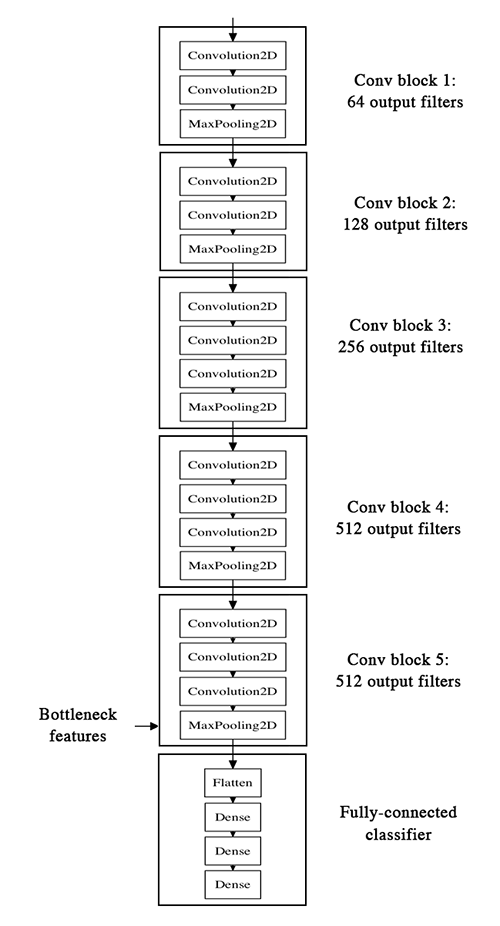

You can find the full code for this experiment [here](https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069). You can get the weights file from [Github](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3). We won't review how the model is built and loaded --this is covered in multiple Keras examples already. But let's take a look at how we record the bottleneck features using image data generators:

In [37]:
!wget --no-check-certificate 'https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/' -O 'bottleneck_fc_model.h5'

In [38]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications


top_model_weights_path = 'bottleneck_fc_model.h5'
nb_train_samples = 576
nb_validation_samples = 96
batch_size=32

In [39]:
datagen = ImageDataGenerator(rescale=1. / 255)

# build the VGG16 network
model_vgg = applications.VGG16(include_top=False, weights='imagenet')

generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
bottleneck_features_train = model_vgg.predict_generator(generator, nb_train_samples // batch_size)
#bottleneck_features_train = model_vgg.predict_generator(generator)

np.save('bottleneck_features_train.npy', bottleneck_features_train)

generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
bottleneck_features_validation = model_vgg.predict_generator(generator, nb_validation_samples // batch_size)
#bottleneck_features_validation = model_vgg.predict_generator(generator)

np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

In [40]:
train_data = np.load('bottleneck_features_train.npy')
train_labels = np.array([0] * int((nb_train_samples / 2)) + [1] * int((nb_train_samples / 2)))

validation_data = np.load('bottleneck_features_validation.npy')
validation_labels = np.array([0] * int((nb_validation_samples / 2)) + [1] * int((nb_validation_samples / 2)))

modelVgg = Sequential()
modelVgg.add(Flatten(input_shape=train_data.shape[1:]))
modelVgg.add(Dense(256, activation='relu'))
modelVgg.add(Dropout(0.5))
modelVgg.add(Dense(1, activation='sigmoid'))

modelVgg.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

early = EarlyStopping(monitor="val_loss", mode="min", patience=10)
check_point = ModelCheckpoint("./my_model_vgg.h5", monitor="val_loss", save_best_only=True)
reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=6)

callbacks_list = [early, check_point, reduce]

modelVgg.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels),
          callbacks=callbacks_list)
modelVgg.save_weights(top_model_weights_path)

In [41]:
# serialize model to JSON
model_json = modelVgg.to_json()
with open("modelVgg.json", "w") as json_file:
    json_file.write(model_json)

In [42]:
with open("modelVgg.json", "r") as json_file:
    json = json_file.read()

# load the json file
# here i use json as loaded content of json file
modelVgg = keras.models.model_from_json(json)
modelVgg.load_weights("my_model_vgg.h5")

In [43]:
# show the confusion matrix of our predictions

# compute predictions
#predictions = model.predict_generator(generator=test_data_gen)
# y_pred = [np.argmax(probas) for probas in predictions]
y_pred =  modelVgg.predict_classes(validation_data, batch_size=None).flatten()

y_test = validation_labels

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)